In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

### Read Synergy Data

In [8]:
s_df = pd.read_csv('nba_offense.csv')
s_df = s_df[s_df['Season'] != 2016]
s_df['Player'] = s_df['Player'].apply(lambda x: ' '.join(x.split(' ')[1:]))
s_df.shape

(3135, 74)

Include labels regarding half court offense only

In [9]:
s_df['Overall_Poss'] = s_df['Overall_Poss'] - s_df['Miscellaneous_Poss']

In [10]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 
                     'Hand Off_Poss%', 'Off Screen_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 
                     'Post-Up_Poss%', 'Transition_Poss%'] 

In [11]:
for col in poss_weights_cols:
    s_df[col] = s_df[col.replace('%', '')] / s_df['Overall_Poss']
    s_df[col] = s_df[col].fillna(0)

Filter in players with 250 shot possessions

In [12]:
s_df = s_df[s_df['Overall_Poss'] >= 200]
s_df.shape

(1774, 74)

### Read BBR Data

In [13]:
bbr_adv_df = pd.read_csv('bbr_nba_advanced_stats.csv')
bbr_adv_df = bbr_adv_df[bbr_adv_df['season'] != 2016]
bbr_adv_df.shape

(3159, 28)

In [14]:
bbr_ros_df = pd.read_csv('bbr_nba_roster_stats.csv')
bbr_ros_df = bbr_ros_df[bbr_ros_df['season'] != 2016]
bbr_ros_df.shape

(2939, 12)

In [15]:
for col in ['player', 'player_alt']:
    bbr_ros_df[col] = bbr_ros_df[col].apply(lambda x: x.replace('(TW)', '').strip())

17-20

In [16]:
bbr_adv_df_17_20 = bbr_adv_df[bbr_adv_df['season'] != 2021].copy()
bbr_ros_df_17_20 = bbr_ros_df[bbr_ros_df['season'] != 2021].copy()
bbr_df_17_20 = bbr_adv_df_17_20.merge(bbr_ros_df_17_20, how='left',
                                      on=['player', 'season', 'team', 'player_alt'])
bbr_adv_df_17_20.shape, bbr_ros_df_17_20.shape, bbr_df_17_20.shape

((2444, 28), (2446, 12), (2444, 36))

Since Basketball-Reference would 'eat' players who were traded in the team page when the season was not 'over', the 21-22 season has to be handled separately.

21-22

In [17]:
bbr_adv_df_21 = bbr_adv_df[bbr_adv_df['season'] == 2021].copy()
bbr_ros_df_21 = bbr_ros_df[bbr_ros_df['season'] == 2021].copy()
bbr_df_21 = bbr_adv_df_21.merge(bbr_ros_df_21, how='left',
                                on=['player', 'season', 'player_alt'])\
                         .rename(columns={'team_x': 'team'})\
                         .drop('team_y', axis=1)
bbr_adv_df_21.shape, bbr_ros_df_21.shape, bbr_df_21.shape

((715, 28), (493, 12), (715, 36))

In [18]:
bbr_df = pd.concat([bbr_df_17_20, bbr_df_21])\
           .reset_index().drop('index', axis=1)

Filter in players that played over 200 minutes

In [19]:
bbr_df = bbr_df[bbr_df['mp'] >= 200]
bbr_df.shape

(2323, 36)

Convert heights

In [20]:
def convert_height(height):
    feet, inches = height.split('-')
    cm = int(feet) * 12 + int(inches)
    return round(cm * 2.54, 1)

In [21]:
bbr_df[bbr_df['height'].isna()].index

Int64Index([2448, 2480, 2500, 2507, 2553, 2576, 2598, 2599, 2600, 2622, 2627,
            2681, 2715, 2718, 2719, 2720, 2762, 2779, 2810, 2835, 2896, 2928,
            2929, 2952, 2967, 3017, 3020, 3024, 3026, 3060, 3070, 3071, 3106],
           dtype='int64')

In [22]:
bbr_df.loc[2448, 'height'] = '6-10'
bbr_df.loc[2448, 'weight'] = 233
bbr_df.loc[2480, 'height'] = '6-10'
bbr_df.loc[2480, 'weight'] = 250
bbr_df.loc[2500, 'height'] = '6-7'
bbr_df.loc[2500, 'weight'] = 240
bbr_df.loc[2507, 'height'] = '6-5'
bbr_df.loc[2507, 'weight'] = 210
bbr_df.loc[2553, 'height'] = '6-7'
bbr_df.loc[2553, 'weight'] = 215
bbr_df.loc[2576, 'height'] = '6-4'
bbr_df.loc[2576, 'weight'] = 220
bbr_df.loc[2598, 'height'] = '6-5'
bbr_df.loc[2598, 'weight'] = 219
bbr_df.loc[2599, 'height'] = '6-0'
bbr_df.loc[2599, 'weight'] = 185
bbr_df.loc[2600, 'height'] = '6-9'
bbr_df.loc[2600, 'weight'] = 240
bbr_df.loc[2622, 'height'] = '6-8'
bbr_df.loc[2622, 'weight'] = 227
bbr_df.loc[2627, 'height'] = '6-6'
bbr_df.loc[2627, 'weight'] = 205
bbr_df.loc[2681, 'height'] = '6-10'
bbr_df.loc[2681, 'weight'] = 214
bbr_df.loc[2715, 'height'] = '6-0'
bbr_df.loc[2715, 'weight'] = 180
bbr_df.loc[2718, 'height'] = '6-5'
bbr_df.loc[2718, 'weight'] = 230
bbr_df.loc[2719, 'height'] = '6-3'
bbr_df.loc[2719, 'weight'] = 210
bbr_df.loc[2720, 'height'] = '6-6'
bbr_df.loc[2720, 'weight'] = 230
bbr_df.loc[2762, 'height'] = '6-8'
bbr_df.loc[2762, 'weight'] = 215
bbr_df.loc[2779, 'height'] = '6-2'
bbr_df.loc[2779, 'weight'] = 200
bbr_df.loc[2810, 'height'] = '6-8'
bbr_df.loc[2810, 'weight'] = 215
bbr_df.loc[2835, 'height'] = '6-6'
bbr_df.loc[2835, 'weight'] = 240
bbr_df.loc[2896, 'height'] = '6-0'
bbr_df.loc[2896, 'weight'] = 184
bbr_df.loc[2928, 'height'] = '7-0'
bbr_df.loc[2928, 'weight'] = 237
bbr_df.loc[2929, 'height'] = '6-8'
bbr_df.loc[2929, 'weight'] = 216
bbr_df.loc[2952, 'height'] = '6-0'
bbr_df.loc[2952, 'weight'] = 170
bbr_df.loc[2967, 'height'] = '6-6'
bbr_df.loc[2967, 'weight'] = 215
bbr_df.loc[3017, 'height'] = '6-9'
bbr_df.loc[3017, 'weight'] = 245
bbr_df.loc[3020, 'height'] = '6-2'
bbr_df.loc[3020, 'weight'] = 205
bbr_df.loc[3024, 'height'] = '6-11'
bbr_df.loc[3024, 'weight'] = 240
bbr_df.loc[3026, 'height'] = '6-3'
bbr_df.loc[3026, 'weight'] = 205
bbr_df.loc[3060, 'height'] = '6-4'
bbr_df.loc[3060, 'weight'] = 180
bbr_df.loc[3070, 'height'] = '6-9'
bbr_df.loc[3070, 'weight'] = 245
bbr_df.loc[3071, 'height'] = '6-11'
bbr_df.loc[3071, 'weight'] = 256
bbr_df.loc[3106, 'height'] = '6-4'
bbr_df.loc[3106, 'weight'] = 226

In [23]:
bbr_df['height_cm'] = bbr_df['height'].apply(convert_height)

Convert weights

In [24]:
bbr_df['weight_kg'] = bbr_df['weight'].apply(lambda x: round(0.453592 * x, 1))

### Merge Synergy Data & BBR Data

In [25]:
s_df['Player_Alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))

In [26]:
bbr_df['player_alt_alt'] = bbr_df['player_alt'].apply(lambda x: x.replace(' ', ''))\
                                               .apply(lambda x: x.replace("'", ''))\
                                               .apply(lambda x: x.replace('.', ''))\
                                               .apply(lambda x: x.lower())

In [27]:
synergy_name_dict = {'kevinknoxii': 'kevinknox',
                     'danilogalinari': 'danilogallinari',
                     'louiswilliams': 'louwilliams',
                     'eneskanter': 'enesfreedom',
                     'terryrozieriii': 'terryrozier',
                     'cameronreddish': 'camreddish',
                     'jahilokafor': 'jahlilokafor',
                     'danuelhouse': 'danuelhousejr',
                     'alfarouqaminu': 'al-farouqaminu',
                     'nenehilario': 'nene',
                     'frankmason': 'frankmasoniii',
                     'larrynance': 'larrynancejr',
                     'wesleyiwundu': 'wesiwundu',
                     'robertwilliamsiii': 'robertwilliams',
                     'harrygilesiii': 'harrygiles',
                     'jamesennis': 'jamesennisiii',
                     'mohamedbamba': 'mobamba',
                     'xaviertillman': 'xaviertillmansr',
                     'patrickbeverly': 'patrickbeverley',
                     'malcomdelaney': 'malcolmdelaney',
                     'marcusmorrissr': 'marcusmorris',
                     'nicolasclaxton': 'nicclaxton',
                     'juanhernangomez': 'juanchohernangomez',
                     'guillermohernangomez': 'willyhernangomez',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot',
                     'nahshonhyland': 'boneshyland'}
s_df['Player_Alt'] = s_df['Player_Alt'].apply(lambda x: synergy_name_dict[x] 
                                              if x in synergy_name_dict.keys()
                                              else x)

In [28]:
df = s_df.merge(bbr_df, how='left', 
                left_on=['Player_Alt', 'Team', 'Season'],
                right_on=['player_alt_alt', 'team', 'season'])
df = df[~df['player_alt_alt'].isna()].reset_index().drop('index', axis=1)
df.shape

(1774, 114)

In [29]:
# check 
df[['Player_Alt', 'Team', 'Season']].drop_duplicates().shape

(1774, 3)

## Functions

In [30]:
poss_ppp_cols = ['Spot Up_PPP', 'P&R Ball Handler_PPP', 
                 'Cut_PPP', 'Hand Off_PPP', 'Offensive Rebounds (put backs)_PPP',
                 'P&R Roll Man_PPP', 'Isolation_PPP', 'Off Screen_PPP',
                 'Post-Up_PPP', 'Transition_PPP']

In [31]:
def find_optimal_k(x):
    avg_ss_list = []
    k_list = list(range(2, 11))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                eigen_solver="arpack",
                                affinity="nearest_neighbors")
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)
        
    top_ss = np.max(avg_ss_list)
    for i in range(len(k_list)):
        if avg_ss_list[i] == top_ss:
            return k_list[i]

In [32]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method Showing the Optimal k')

In [33]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 8))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 7, color='red', linestyle='--')
    plt.xlabel('Number of Components (c)')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Results')

In [34]:
def get_playtype_dist(df, poss_ppp_cols=poss_ppp_cols):
    playtype_dfs = []
    for col in poss_ppp_cols:
        playtype = col.replace('_PPP', '')
        playtype_df = pd.DataFrame()
        playtype_df['PPP'] = df[col]
        playtype_df['Poss%'] = df[f'{playtype}_Poss%'] * 100
        playtype_df['playtype'] = playtype
        playtype_dfs.append(playtype_df)   
    return pd.concat(playtype_dfs)

In [35]:
def show_cluster_res(df, cluster_col, poss_weights_cols=poss_weights_cols):
    cluster_res = df.groupby(cluster_col)[['usg_pct', 'obpm'] + poss_weights_cols]\
                    .mean().sort_values('obpm', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['obpm'] = cluster_res['obpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['usg_pct'] = cluster_res['usg_pct'].apply(lambda x: f'{x:.1f}%')
    for col in cluster_res.columns:
        if '%' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

In [36]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [37]:
def check_cluster_robustness(x, k, n_iters):
    cluster_res = []
    for i in range(n_iters):
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
        pred = sc.fit(x).labels_
        res = sorted([list(pred).count(cluster) for cluster in list(range(k))])
        cluster_res.append('-'.join([str(n) for n in res]))
    return Counter(cluster_res)

In [38]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'obpm']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('obpm', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('obpm')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

## Clustering

Show correlations among playtype possession%

Text(0.5, 1.0, 'Correlations Among Playtypes in NBA (2017-2022)')

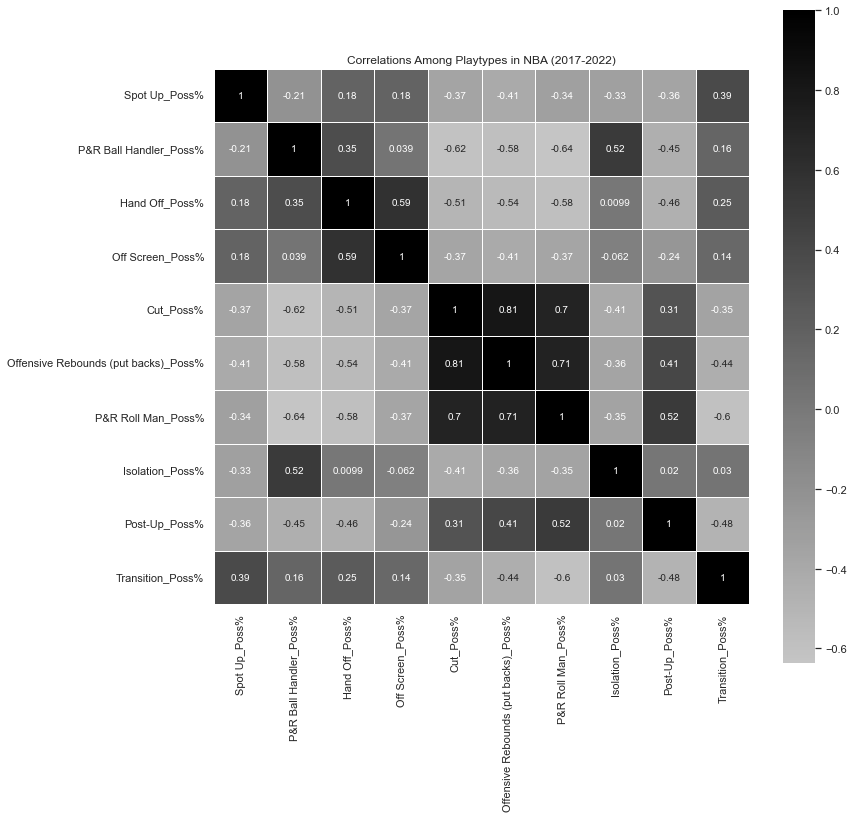

In [39]:
figsize(12, 8)
corr = df[poss_weights_cols].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,
            square=True, annot=True, linewidths=.5)
plt.title('Correlations Among Playtypes in NBA (2017-2022)')

Show distributions of possession weights and effeiciency of each playtype

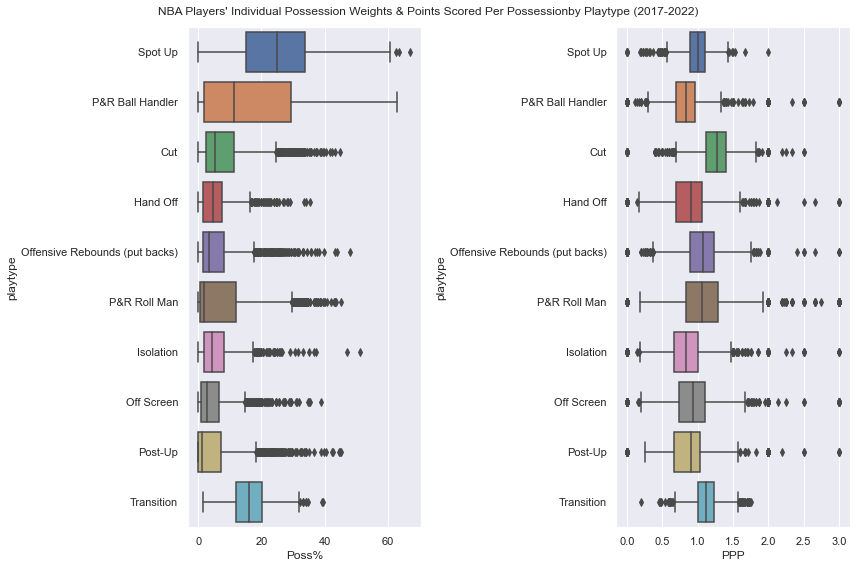

In [40]:
figsize(12, 8)
data = get_playtype_dist(df)
suptitle = ("NBA Players' Individual " 
            'Possession Weights & '
            'Points Scored Per Possession'
            'by Playtype (2017-2022)')
plt.suptitle(suptitle)
plt.subplot(1, 2, 1)
sns.boxplot(x="Poss%", y="playtype", data=data)
plt.subplot(1, 2, 2)
sns.boxplot(x="PPP", y="playtype", data=data)
plt.tight_layout()

Summary of distribution in playtype weights:
- Outliers exist 
    - Most of them are the result of skewed data
    - A few of them are creditted to players' own unique tendencies (ex. James Harden's iso game)
- There are some common playtypes
    - Spot Up
    - Transition
- Most are skewed
    - Big man
        - Cut
        - Offensive Rebounds
        - P&R Roll Man
        - Post-Up
    - Perimeter players
        - P&R Ball Handler
        - Hand Off
        - Off Screen
    - Star Privilege
        - Post-Up
        - Isolation
    
        

### Clustering

In [41]:
X = df[poss_weights_cols].copy()

Determine how many components reduce down to via PCA

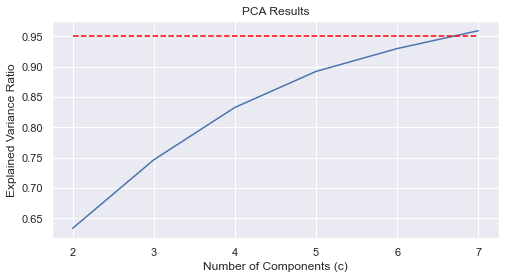

In [42]:
figsize(8, 4)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choose 7

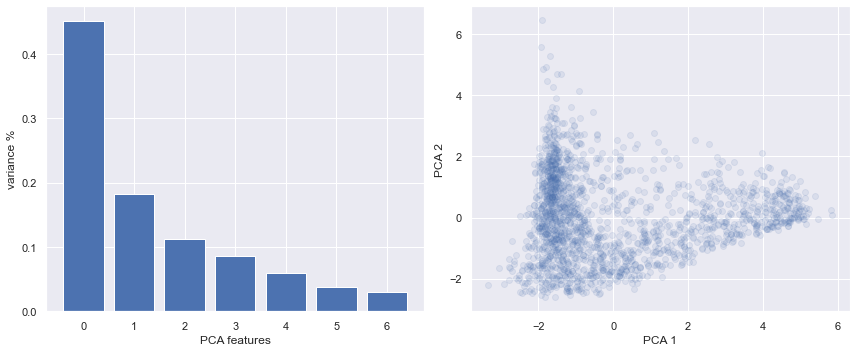

In [43]:
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=7)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [44]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

Determine # of clusters using silhouette score method

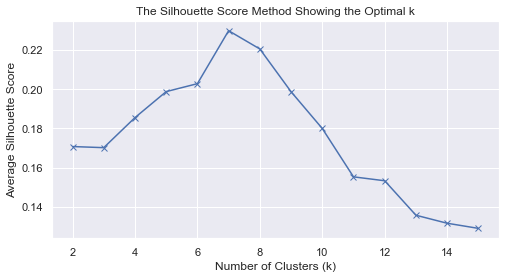

In [45]:
figsize(8, 4)
plot_silhouette_score(X_transformed)

Try 500 times to see if the clustering result stays robust. It turns out the algorithm delivers the same result 

In [46]:
# # Check stability
# check_cluster_robustness(X_transformed, 7, 500)

### Results

In [47]:
# Choose k = 7
sc = SpectralClustering(n_clusters=7, affinity='nearest_neighbors', random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    161
1    448
2    197
3    580
4     43
5    165
6    180
Name: Player, dtype: int64

#### OBPM & Usage by Cluster

In [48]:
show_cluster_res(df, 'player_cluster').T

,player_cluster,usg_pct,obpm,Spot Up_Poss%,P&R Ball Handler_Poss%,Hand Off_Poss%,Off Screen_Poss%,Cut_Poss%,Offensive Rebounds (put backs)_Poss%,P&R Roll Man_Poss%,Isolation_Poss%,Post-Up_Poss%,Transition_Poss%,#
0,2,25.9%,1.91,17.70%,26.18%,5.16%,4.52%,3.54%,2.65%,2.18%,16.44%,5.72%,15.77%,197
1,6,22.9%,1.18,15.28%,2.13%,1.18%,2.12%,12.29%,10.85%,19.17%,4.73%,22.49%,9.69%,180
2,0,20.6%,0.27,27.23%,16.01%,8.53%,16.17%,4.27%,2.05%,1.32%,4.41%,1.14%,18.71%,161
3,5,16.0%,-0.20,6.86%,0.23%,0.23%,0.25%,27.70%,21.15%,25.66%,1.65%,6.75%,9.39%,165
4,1,21.1%,-0.45,22.43%,36.88%,6.89%,3.48%,2.90%,1.92%,0.57%,6.90%,0.72%,17.21%,448
5,4,17.8%,-0.64,27.87%,11.28%,22.19%,13.43%,5.07%,1.76%,1.26%,1.59%,0.11%,15.32%,43
6,3,16.6%,-1.19,36.50%,7.02%,4.37%,3.63%,9.15%,6.17%,7.45%,3.08%,3.39%,19.10%,580


- Ballhandler: 2 & 1
- Big: 6 & 5
- Wing: 0 & 4 & 3

In [49]:
cluster_dict = {2: 'Ballhandler', 1: 'Ballhandler',
                6: 'Big', 5: 'Big',
                0: 'Wing', 4: 'Wing', 3: 'Wing'}

In [50]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [51]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [52]:
show_cluster_res(df, 'player_cluster')\
.style.applymap(color_cluster_pandas)

,0,1,2,3,4,5,6
player_cluster,2,6,0,5,1,4,3
usg_pct,25.9%,22.9%,20.6%,16.0%,21.1%,17.8%,16.6%
obpm,1.91,1.18,0.27,-0.20,-0.45,-0.64,-1.19
Spot Up_Poss%,17.70%,15.28%,27.23%,6.86%,22.43%,27.87%,36.50%
P&R Ball Handler_Poss%,26.18%,2.13%,16.01%,0.23%,36.88%,11.28%,7.02%
Hand Off_Poss%,5.16%,1.18%,8.53%,0.23%,6.89%,22.19%,4.37%
Off Screen_Poss%,4.52%,2.12%,16.17%,0.25%,3.48%,13.43%,3.63%
Cut_Poss%,3.54%,12.29%,4.27%,27.70%,2.90%,5.07%,9.15%
Offensive Rebounds (put backs)_Poss%,2.65%,10.85%,2.05%,21.15%,1.92%,1.76%,6.17%
P&R Roll Man_Poss%,2.18%,19.17%,1.32%,25.66%,0.57%,1.26%,7.45%


#### Possession Weights by Cluster

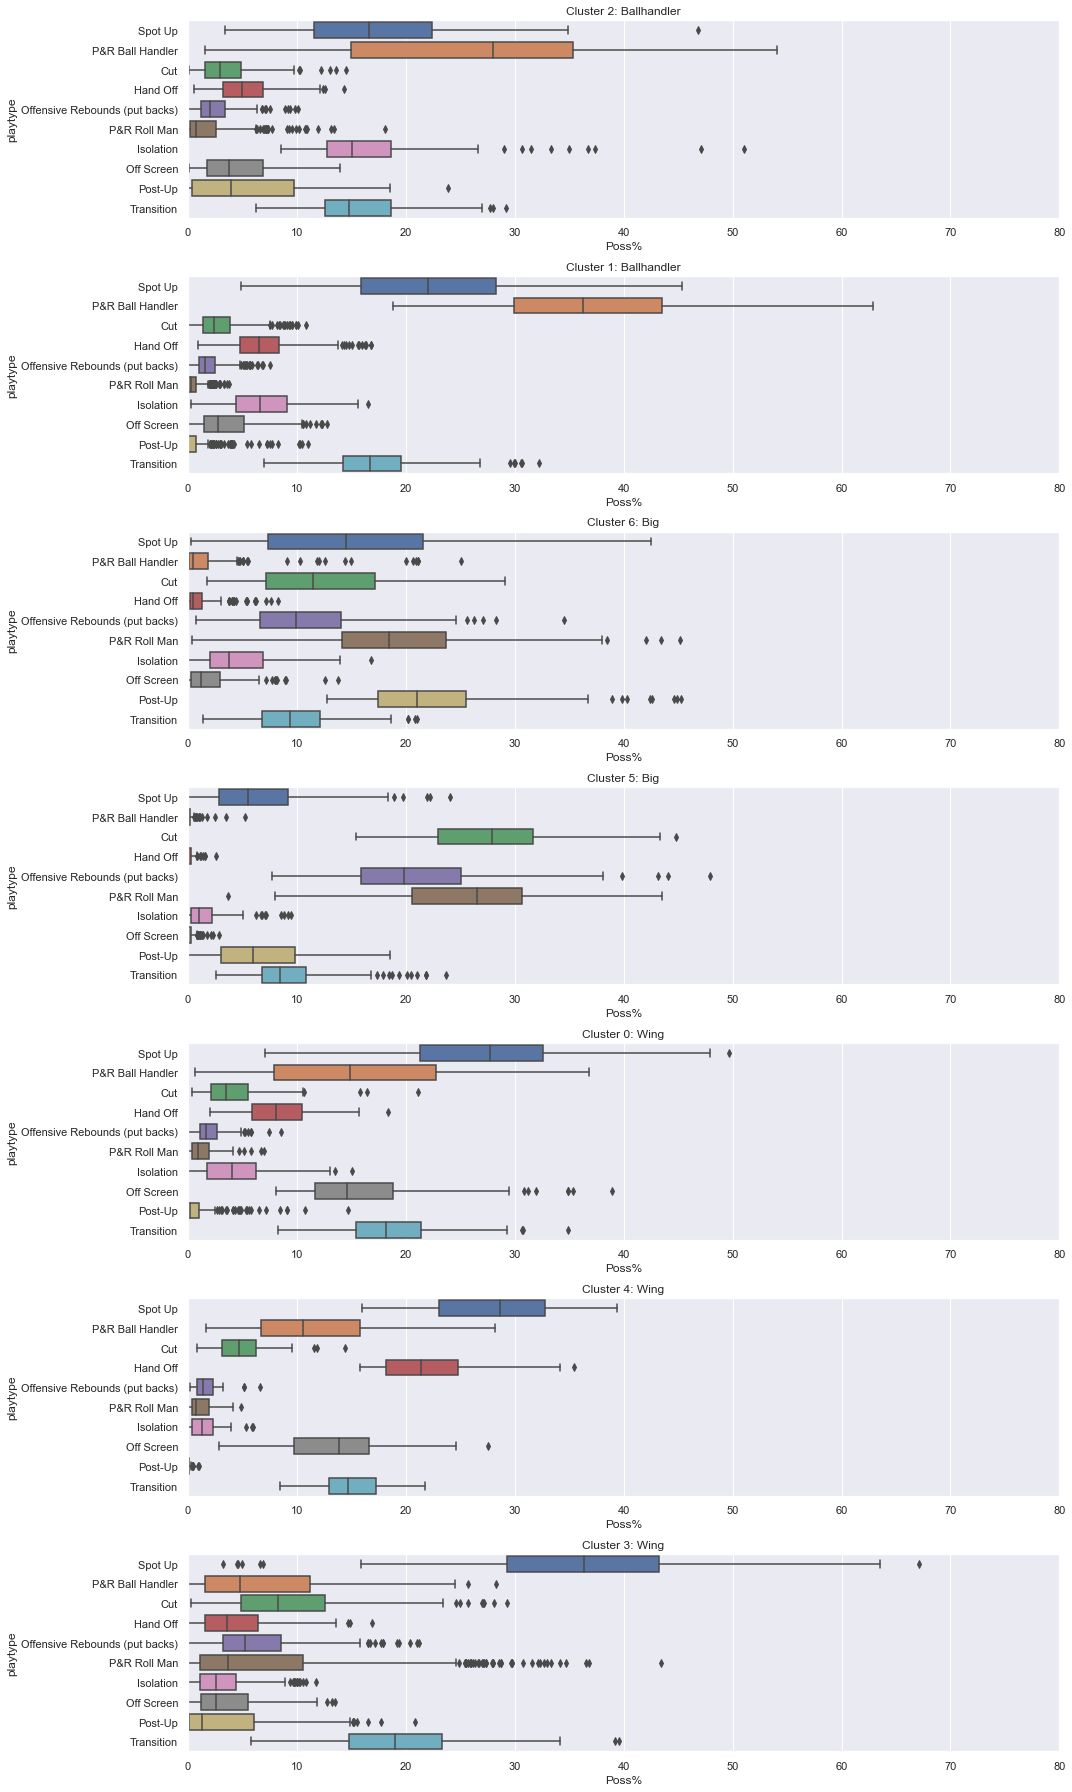

In [53]:
figsize(15, 25)
n_clusters = len(set(df['player_cluster']))
data_dict = {cluster: get_playtype_dist(df[df['player_cluster'] == cluster])
             for cluster in range(n_clusters)}

for idx, cluster in enumerate(list(cluster_dict.keys()), 1):
    data = get_playtype_dist(df[df['player_cluster'] == cluster])
    plt.subplot(n_clusters, 1, idx)
    sns.boxplot(x="Poss%", y="playtype", data=data_dict[cluster])
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}')
    plt.xlim(0, 80)

plt.tight_layout()

Summary of distribution in playtype weights:
- Good:
    - Cluster separate playtypes regarding pick & roll nicely
    - Cluster separate iso & post-up nicely
- Bad:
    - Skewed data & Outliers still exist

#### Observations

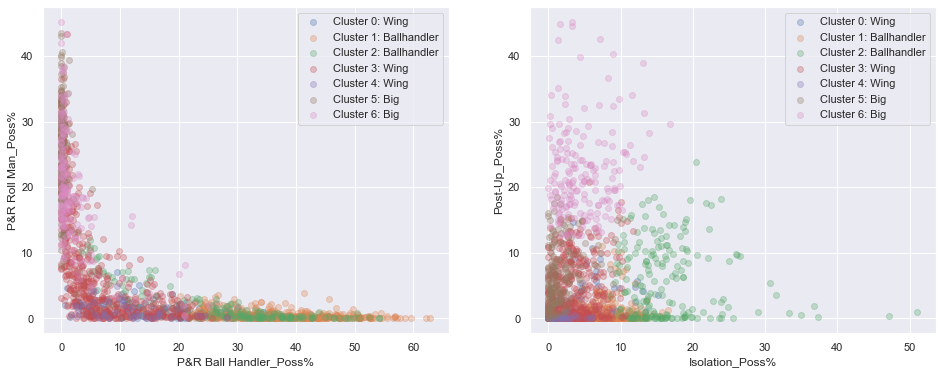

In [54]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)

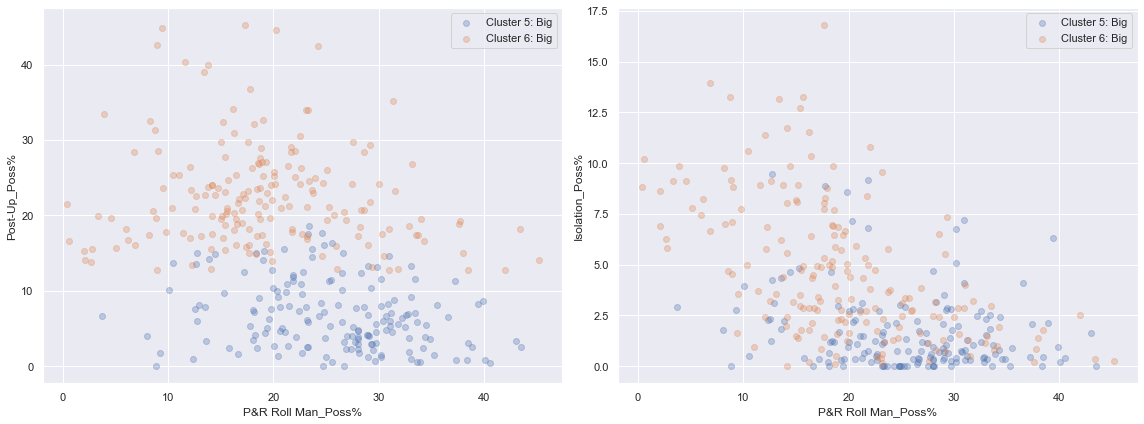

In [55]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

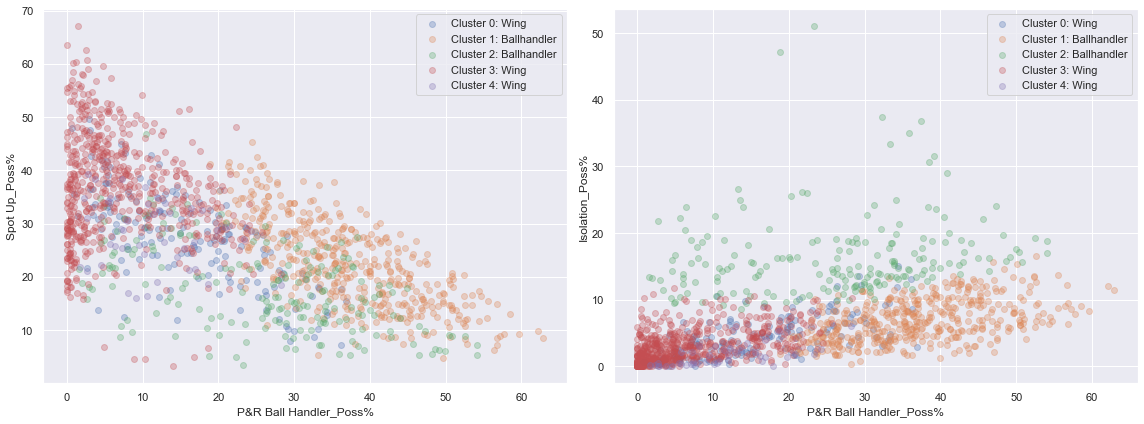

In [56]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

#### Distributions

Height & Weight

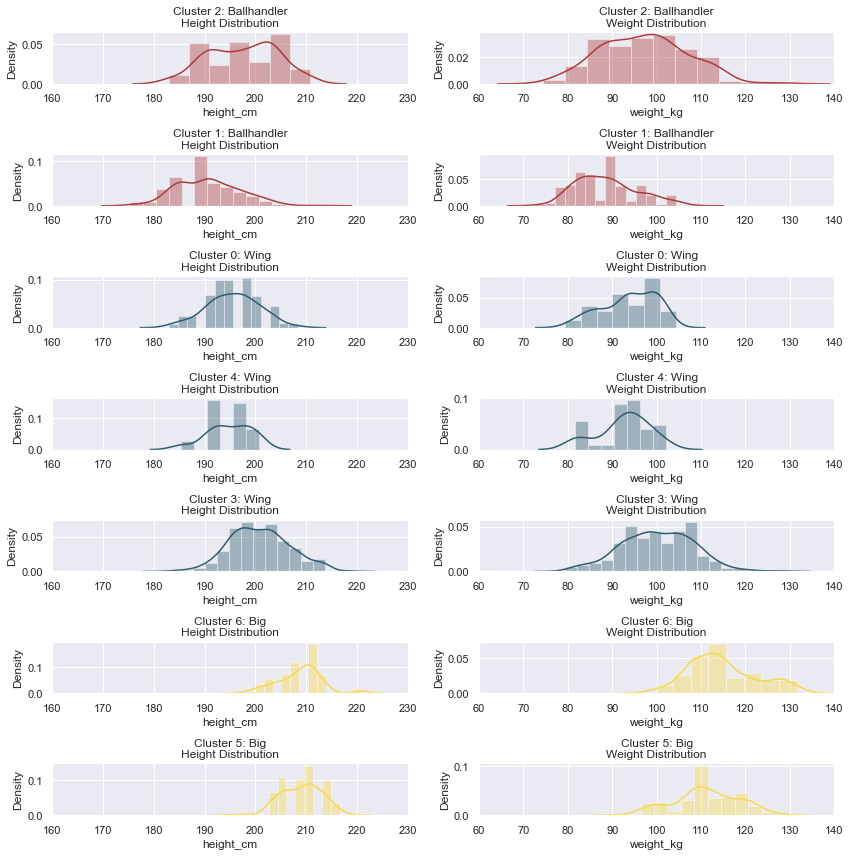

In [57]:
figsize(12, 20)
for idx, cluster in enumerate([2, 1, 0, 4, 3, 6, 5], 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, idx*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['height_cm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nHeight Distribution')
    plt.xlim(160, 230)
    plt.subplot(12, 2, idx*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['weight_kg'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nWeight Distribution')
    plt.xlim(60, 140)
plt.tight_layout()

PPP & Shooting

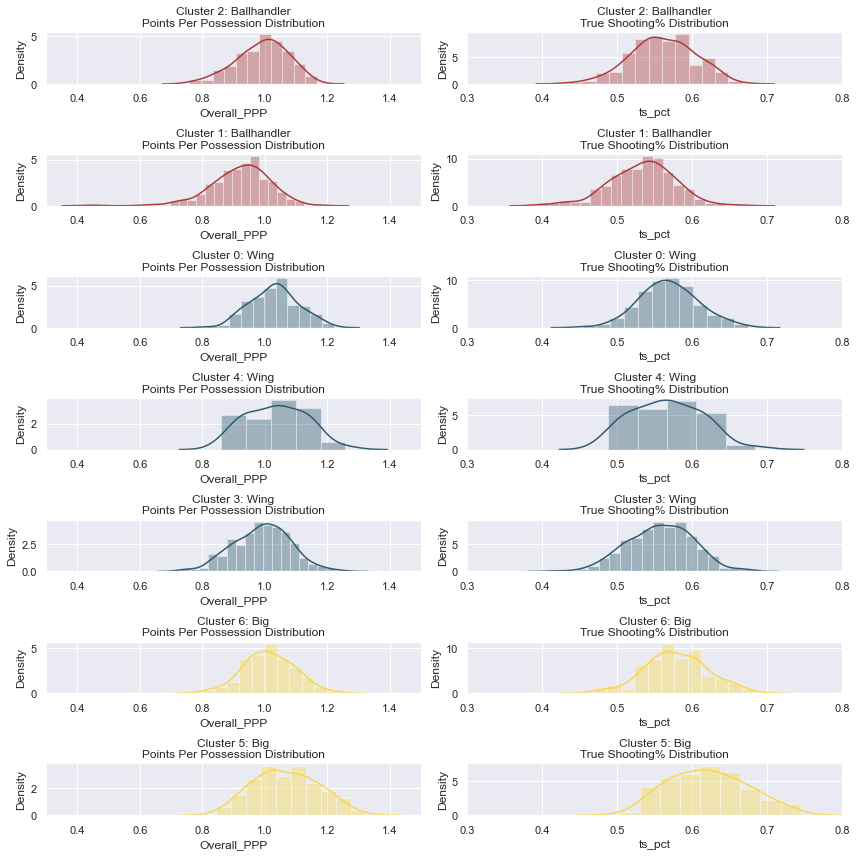

In [58]:
figsize(12, 20)
for idx, cluster in enumerate([2, 1, 0, 4, 3, 6, 5], 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, idx*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['Overall_PPP'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nPoints Per Possession Distribution')
    plt.xlim(0.3, 1.5)
    plt.subplot(12, 2, idx*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['ts_pct'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nTrue Shooting% Distribution')
    plt.xlim(0.3, 0.8)
plt.tight_layout()

Usage & OBPM Distribution

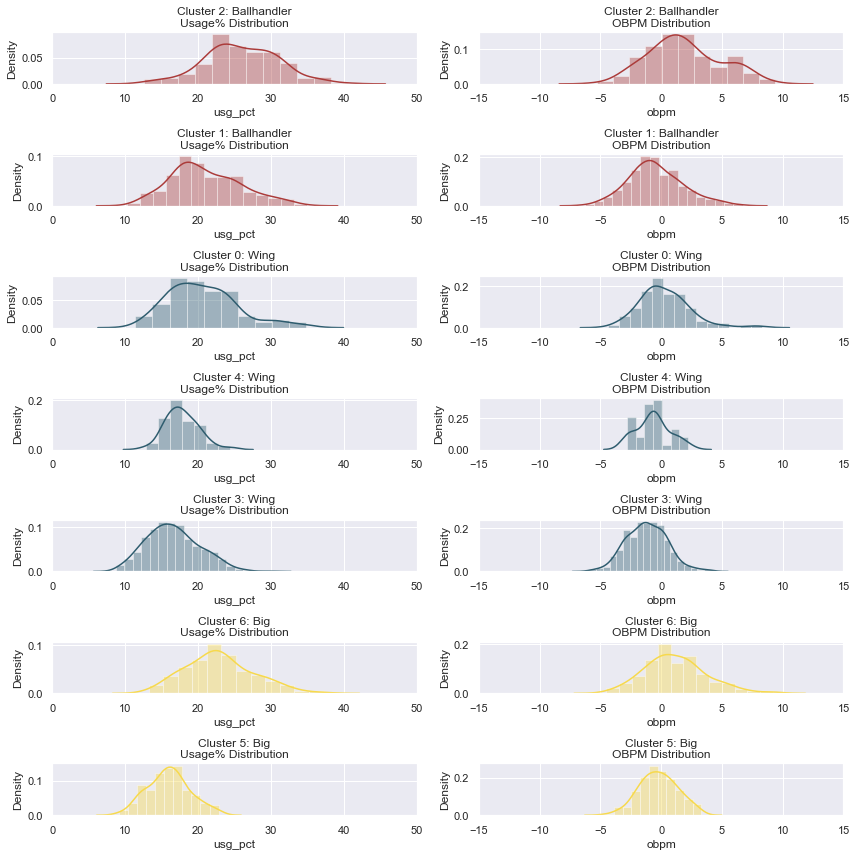

In [59]:
figsize(12, 20)
for i, cluster in enumerate([2, 1, 0, 4, 3, 6, 5], 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['usg_pct'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nUsage% Distribution')
    plt.xlim(0, 50)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['obpm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nOBPM Distribution')
    plt.xlim(-15, 15)
plt.tight_layout()

#### Top & Bottom Players by Cluster

##### Ballhandlers

In [60]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 197


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,James Harden,2018,Houston Rockets,9.4,Rodney Hood,2020,Portland Trail Blazers,-5.3
1,James Harden,2017,Houston Rockets,8.5,Austin Rivers,2018,Washington Wizards,-4.1
2,Damian Lillard,2019,Portland Trail Blazers,8.3,Trey Burke,2021,Dallas Mavericks,-3.6
3,James Harden,2019,Houston Rockets,8.1,Austin Rivers,2021,Denver Nuggets,-3.5
4,Giannis Antetokounmpo,2021,Milwaukee Bucks,7.6,Keon Johnson,2021,Portland Trail Blazers,-3.5
5,Damian Lillard,2020,Portland Trail Blazers,7.5,Kevin Porter Jr.,2019,Cleveland Cavaliers,-3.2
6,Luka Doncic,2019,Dallas Mavericks,7.4,Austin Rivers,2018,Houston Rockets,-2.9
7,Giannis Antetokounmpo,2019,Milwaukee Bucks,7.4,Dennis Smith Jr.,2021,Portland Trail Blazers,-2.8
8,LeBron James,2017,Cleveland Cavaliers,7.3,Brandon Williams,2021,Portland Trail Blazers,-2.6
9,Trae Young,2021,Atlanta Hawks,7.1,Anfernee Simons,2019,Portland Trail Blazers,-2.6


In [61]:
temp = df[df['player_cluster'] == 2].groupby('Player')['Season'].count()\
                                    .reset_index().sort_values('Season', ascending=False)
temp[temp['Season'] > 1]

,Player,Season
36,James Harden,6
73,Russell Westbrook,5
29,Giannis Antetokounmpo,5
5,Austin Rivers,5
45,Jordan Clarkson,5
7,Brandon Ingram,5
9,CJ McCollum,5
38,Jayson Tatum,5
18,DeMar DeRozan,5
53,Khris Middleton,5


In [62]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 448


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Kyrie Irving,2019,Brooklyn Nets,6.7,Killian Hayes,2020,Detroit Pistons,-6.3
1,Ja Morant,2021,Memphis Grizzlies,6.2,Justise Winslow,2020,Memphis Grizzlies,-6.2
2,Trae Young,2019,Atlanta Hawks,6.2,Jawun Evans,2017,Los Angeles Clippers,-5.4
3,Jimmy Butler,2020,Miami Heat,5.4,Jalen Suggs,2021,Orlando Magic,-5.3
4,CJ McCollum,2021,New Orleans Pelicans,5.3,Frank Ntilikina,2018,New York Knicks,-5.2
5,Trae Young,2020,Atlanta Hawks,5.3,Dennis Smith Jr.,2019,New York Knicks,-5.2
6,Kemba Walker,2018,Charlotte Hornets,5.2,Aleksej Pokusevski,2020,Oklahoma City Thunder,-5.1
7,Kemba Walker,2019,Boston Celtics,4.9,Dwayne Bacon,2017,Charlotte Hornets,-4.8
8,Zach Lavine,2020,Chicago Bulls,4.9,Chasson Randle,2020,Orlando Magic,-4.8
9,Kemba Walker,2017,Charlotte Hornets,4.7,Kobi Simmons,2017,Memphis Grizzlies,-4.7


##### Bigs

In [63]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 180


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Nikola Jokic,2021,Denver Nuggets,9.2,Zach Collins,2017,Portland Trail Blazers,-4.5
1,Nikola Jokic,2020,Denver Nuggets,9.1,James Wiseman,2020,Golden State Warriors,-4.0
2,Joel Embiid,2021,Philadelphia 76ers,7.2,Aron Baynes,2017,Boston Celtics,-3.6
3,Anthony Davis,2018,New Orleans Pelicans,7.1,Greg Monroe,2018,Toronto Raptors,-3.5
4,Karl-Anthony Towns,2019,Minnesota Timberwolves,7.0,Harry Giles,2018,Sacramento Kings,-3.4
5,Joel Embiid,2020,Philadelphia 76ers,6.3,Robin Lopez,2019,Milwaukee Bucks,-3.0
6,Nikola Jokic,2018,Denver Nuggets,6.2,Evan Turner,2017,Portland Trail Blazers,-2.9
7,Nikola Vucevic,2020,Orlando Magic,5.5,DeMarcus Cousins,2021,Denver Nuggets,-2.8
8,Nikola Jokic,2019,Denver Nuggets,5.5,Cristiano Felicio,2017,Chicago Bulls,-2.8
9,Kristaps Porzingis,2021,Washington Wizards,5.4,Andre Drummond,2020,Los Angeles Lakers,-2.7


In [64]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 165


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Clint Capela,2018,Houston Rockets,3.3,Ian Mahinmi,2017,Washington Wizards,-4.6
1,Brandon Clarke,2021,Memphis Grizzlies,3.1,Miles Plumlee,2017,Atlanta Hawks,-3.7
2,Rudy Gobert,2018,Utah Jazz,3.0,Precious Achiuwa,2020,Miami Heat,-3.6
3,Robert Williams III,2020,Boston Celtics,2.9,Bismack Biyombo,2020,Charlotte Hornets,-3.4
4,Rudy Gobert,2021,Utah Jazz,2.9,Aron Baynes,2020,Toronto Raptors,-3.4
5,Jarrett Allen,2021,Cleveland Cavaliers,2.7,Alex Len,2021,Sacramento Kings,-3.2
6,Clint Capela,2020,Atlanta Hawks,2.7,Ian Mahinmi,2019,Washington Wizards,-2.8
7,Hassan Whiteside,2019,Portland Trail Blazers,2.5,Zaza Pachulia,2018,Detroit Pistons,-2.8
8,Robert Williams III,2021,Boston Celtics,2.4,Bismack Biyombo,2017,Orlando Magic,-2.6
9,Clint Capela,2017,Houston Rockets,2.4,Khem Birch,2019,Orlando Magic,-2.5


##### Wings

In [65]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 161


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Stephen Curry,2020,Golden State Warriors,8.3,Jordan Poole,2019,Golden State Warriors,-4.4
1,Stephen Curry,2017,Golden State Warriors,7.8,Gary Harris,2020,Orlando Magic,-3.6
2,Stephen Curry,2018,Golden State Warriors,7.1,Ben McLemore,2020,Houston Rockets,-3.4
3,Stephen Curry,2021,Golden State Warriors,5.4,Justin Holiday,2018,Memphis Grizzlies,-3.3
4,Bradley Beal,2019,Washington Wizards,5.3,Ian Clark,2018,New Orleans Pelicans,-3.3
5,Bradley Beal,2020,Washington Wizards,4.8,CJ Miles,2018,Toronto Raptors,-3.2
6,Paul George,2020,Los Angeles Clippers,3.9,Ben McLemore,2017,Memphis Grizzlies,-2.9
7,Paul George,2019,Los Angeles Clippers,3.8,Jake Layman,2019,Minnesota Timberwolves,-2.8
8,Bradley Beal,2018,Washington Wizards,3.8,Ian Clark,2017,New Orleans Pelicans,-2.7
9,Buddy Hield,2018,Sacramento Kings,3.5,Devin Harris,2018,Dallas Mavericks,-2.6


In [66]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 43


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,JJ Redick,2017,Philadelphia 76ers,2.2,Avery Bradley,2017,Detroit Pistons,-2.8
1,JJ Redick,2018,Philadelphia 76ers,2.2,Gary Harris,2019,Denver Nuggets,-2.8
2,Duncan Robinson,2019,Miami Heat,1.5,Terrence Ross,2017,Orlando Magic,-2.8
3,Doug McDermott,2019,Indiana Pacers,1.4,Ignas Brazdeikis,2021,Orlando Magic,-2.7
4,Doug McDermott,2020,Indiana Pacers,1.4,Armoni Brooks,2021,Houston Rockets,-2.6
5,Wayne Ellington,2020,Detroit Pistons,1.1,Justin Holiday,2021,Sacramento Kings,-2.6
6,Gary Harris,2017,Denver Nuggets,1.0,Terrence Ross,2021,Orlando Magic,-2.5
7,Wayne Ellington,2017,Miami Heat,1.0,Rodney McGruder,2018,Miami Heat,-2.2
8,Reggie Bullock,2017,Detroit Pistons,0.7,Gary Harris,2021,Orlando Magic,-2.0
9,Marco Belinelli,2017,Philadelphia 76ers,0.0,Troy Daniels,2018,Phoenix Suns,-1.7


In [67]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 580


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Danilo Galinari,2019,Oklahoma City Thunder,4.1,Dwayne Bacon,2019,Charlotte Hornets,-5.9
1,Michael Porter Jr.,2020,Denver Nuggets,4.0,Tyrone Wallace,2018,Los Angeles Clippers,-5.6
2,Mike Muscala,2021,Oklahoma City Thunder,3.8,Paul Zipser,2017,Chicago Bulls,-5.5
3,John Collins,2019,Atlanta Hawks,3.7,Sekou Doumbouya,2020,Detroit Pistons,-5.4
4,Christian Wood,2019,Detroit Pistons,3.5,Sekou Doumbouya,2019,Detroit Pistons,-5.2
5,Jaylen Brown,2020,Boston Celtics,3.2,Treveon Graham,2019,Minnesota Timberwolves,-5.0
6,Bam Adebayo,2020,Miami Heat,2.9,Aaron Nesmith,2021,Boston Celtics,-4.9
7,Jalen Smith,2021,Indiana Pacers,2.9,Lance Thomas,2018,New York Knicks,-4.8
8,Thomas Bryant,2019,Washington Wizards,2.9,Terrance Ferguson,2019,Oklahoma City Thunder,-4.8
9,John Collins,2018,Atlanta Hawks,2.8,Corey Brewer,2017,Los Angeles Lakers,-4.7


#### Edge Cases

In [68]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster
127,DeMarcus Cousins,"{2, 3, 6}","{Wing, Ballhandler, Big}",3
210,Harrison Barnes,"{2, 3, 6}","{Wing, Ballhandler, Big}",3
500,Rondae Hollis-Jefferson,"{2, 3, 5}","{Big, Ballhandler, Wing}",3
554,Tobias Harris,"{2, 3, 6}","{Big, Ballhandler, Wing}",3


In [69]:
temp[(temp['n_cluster'] == 2) & (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster
70,Carmelo Anthony,"{2, 6}","{Ballhandler, Big}",2
320,Julius Randle,"{2, 6}","{Ballhandler, Big}",2
326,Karl-Anthony Towns,"{2, 6}","{Ballhandler, Big}",2
607,Zion Williamson,"{2, 6}","{Ballhandler, Big}",2


### Visualization via TSNE

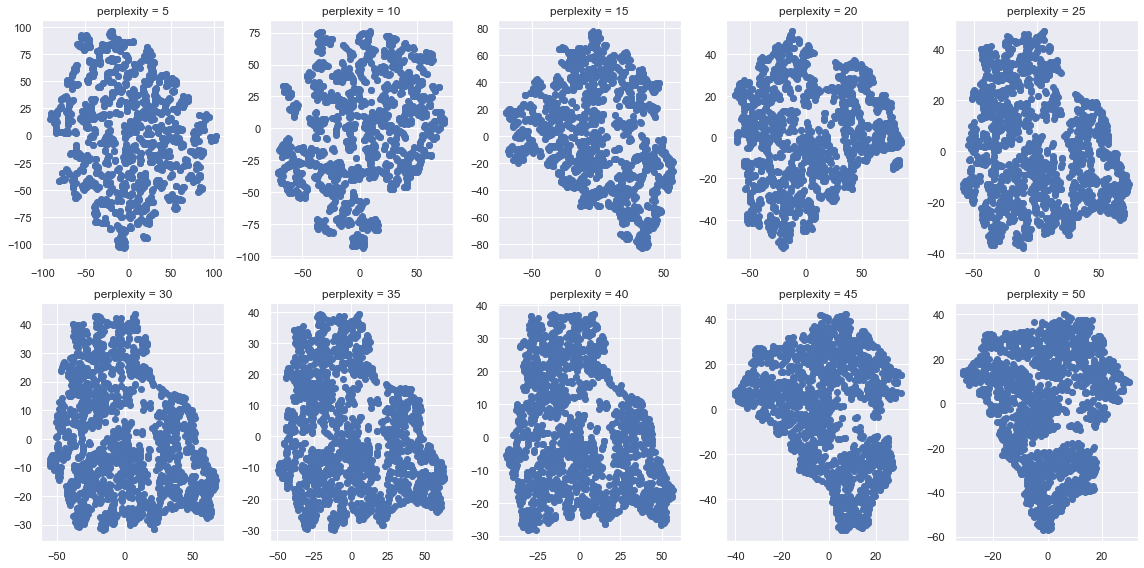

In [70]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [71]:
tsne = TSNE(perplexity=20, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

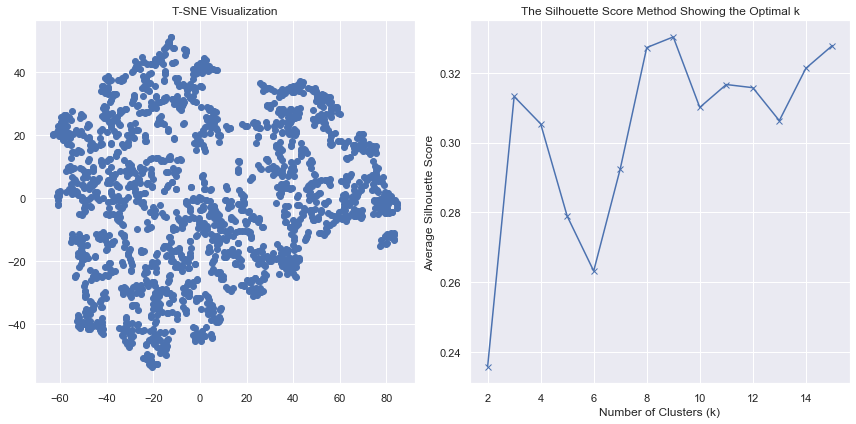

In [72]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [73]:
df_tsne = df.copy()
# Choose k = 9
sc_tsne = SpectralClustering(n_clusters=9, affinity='nearest_neighbors', random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

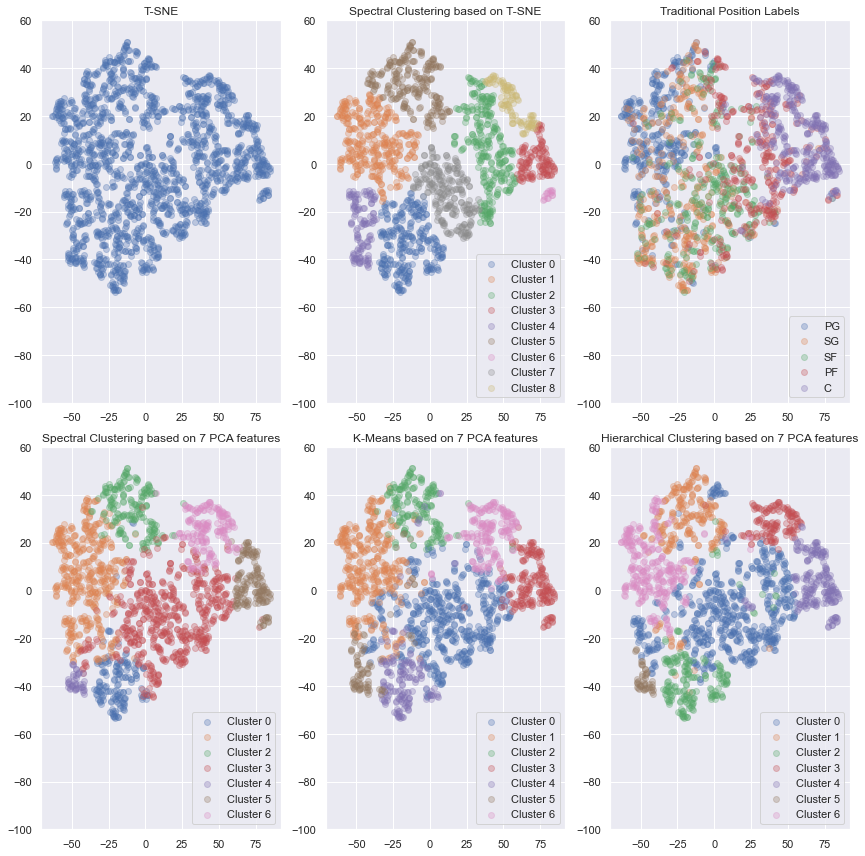

In [74]:
figsize(12, 12)

plt.subplot(2, 3, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')
plt.ylim(-100, 60)

plt.subplot(2, 3, 2)
for i in range(9):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(2, 3, 3)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], X_tsne[pos_index, 1], label=pos, alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title('Traditional Position Labels')

n_clusters = 7

plt.subplot(2, 3, 4)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title(f'Spectral Clustering based on {n_clusters} PCA features')


plt.subplot(2, 3, 5)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title(f'K-Means based on {n_clusters} PCA features')

plt.subplot(2, 3, 6)
agc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                              linkage='ward')
labels = agc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title(f'Hierarchical Clustering based on {n_clusters} PCA features')

plt.tight_layout()

Text(0.5, 1.0, 'Spectral Clustering based on 7 PCA features')

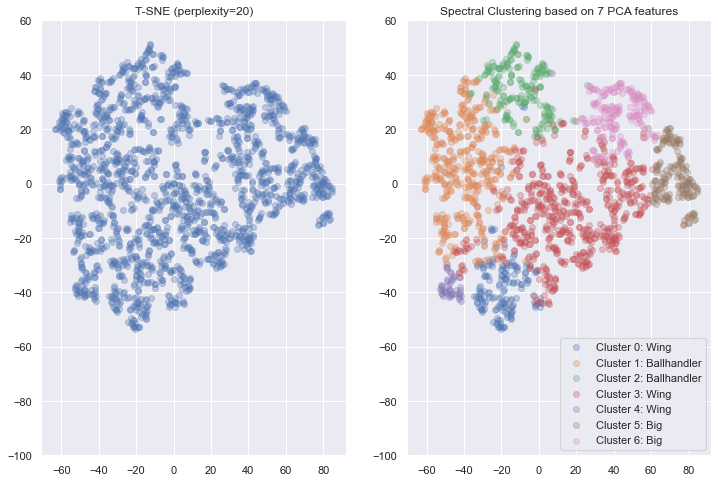

In [84]:
figsize(12, 8)

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE (perplexity=20)')
plt.ylim(-100, 60)

n_clusters = 7

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title(f'Spectral Clustering based on {n_clusters} PCA features')

Text(0.5, 1.0, 'Spectral Clustering based on 7 PCA features')

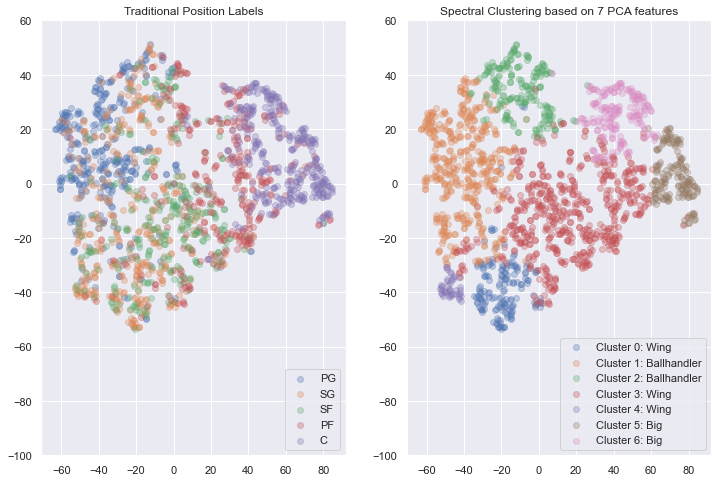

In [75]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], X_tsne[pos_index, 1], label=pos, alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title('Traditional Position Labels')

n_clusters = 7

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title(f'Spectral Clustering based on {n_clusters} PCA features')

Text(0.5, 1.0, 'Spectral Clustering based on 7 PCA features')

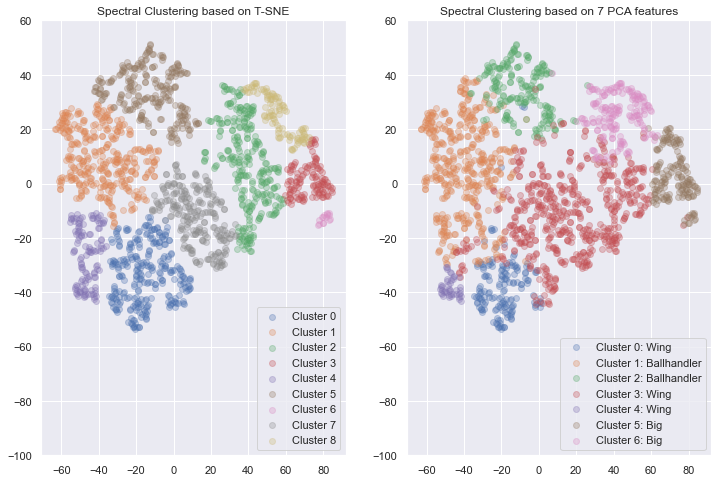

In [76]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for i in range(9):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title('Spectral Clustering based on T-SNE')

n_clusters = 7

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title(f'Spectral Clustering based on {n_clusters} PCA features')

(-100.0, 60.0)

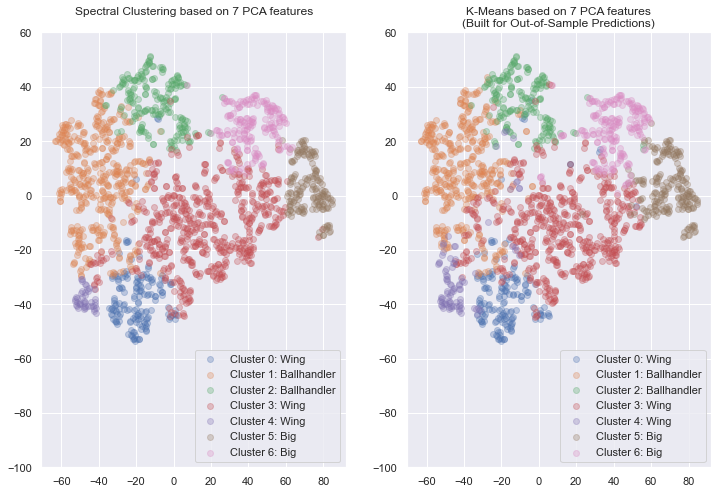

In [83]:
figsize(12, 8)

cluster_map_km_to_sc = {0: 3, 
                        1: 1, 
                        2: 2, 
                        3: 5, 
                        4: 0, 
                        5: 4, 
                        6: 6}

n_clusters = 7

plt.subplot(1, 2, 1)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title(f'Spectral Clustering based on {n_clusters} PCA features\n')

plt.subplot(1, 2, 2)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
labels = [cluster_map_km_to_sc[label] for label in labels]
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
oos = '(Built for Out-of-Sample Predictions)'
plt.title(f'K-Means based on {n_clusters} PCA features\n{oos}')
plt.legend(loc='lower right')
plt.ylim(-100, 60)

## Save Models

In [78]:
# df.to_csv('nba_cleaned.csv', index=False)

In [79]:
# nba_clustering_models = {'pre_pca_pipe': pre_pca_pipe,
#                          'pca': pca,
#                          'pre_cluster_scaler': pre_cluster_scaler,
#                          'cluster_dict': cluster_dict}
# dump_pickle(nba_clustering_models, 'nba_clustering_models')

In [80]:
# cluster_map_km_to_sc = {0: 3, 
#                         1: 1, 
#                         2: 2, 
#                         3: 5, 
#                         4: 0, 
#                         5: 4, 
#                         6: 6}
# nba_clustering_models_km = {'pre_pca_pipe': pre_pca_pipe,
#                             'pca': pca,
#                             'pre_cluster_scaler': pre_cluster_scaler,
#                             'cluster_map_to_spectral_clustering': cluster_map_km_to_sc,
#                             'km': km}
# dump_pickle(nba_clustering_models_km, 'nba_clustering_models_km')